In [2]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import image
import numpy
from tqdm import tqdm
from utils import * 


rgb = image.imread("euler.jpg")
lines, columns = rgb.shape[:-1]

def rgb2gray(rgb):
    return numpy.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))

#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 30000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1),((1-(categorical_samples//columns + torch.rand(num_samples))/lines)).unsqueeze(-1)], dim = -1)

mean = torch.mean(target_samples, dim = 0)
cov = torch.cov(target_samples.T)
instrumental = torch.distributions.MultivariateNormal(mean, (cov + cov.T)/2)
proposed_samples = instrumental.sample([num_samples])

In [3]:
from classifiers import BinaryClassifier
ratio = torch.load('model.sav')

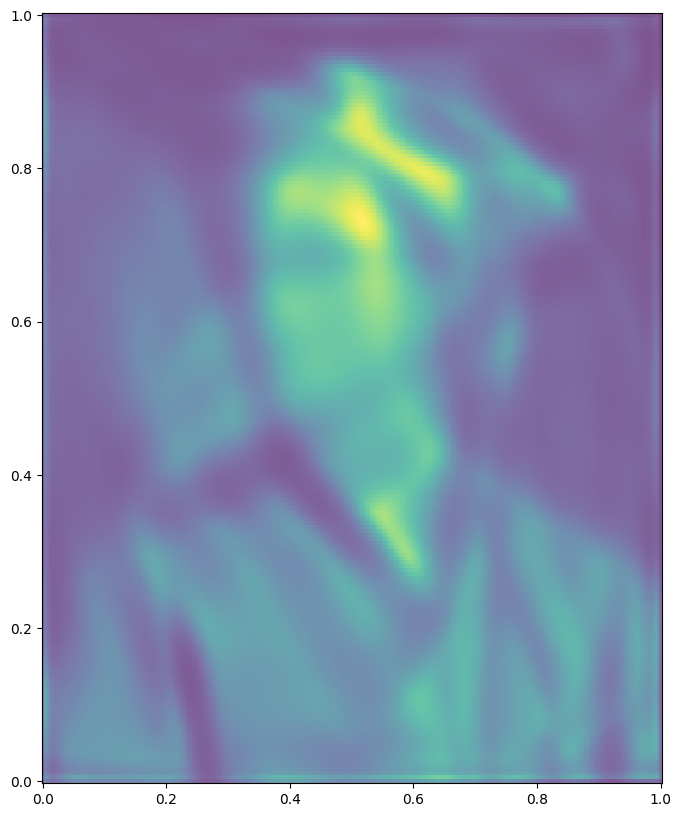

In [5]:
plot_2d_function(lambda x : torch.exp(ratio.logit_r(x).squeeze(-1) + instrumental.log_prob(x)), bins = (lines, columns), range = [[0,1],[0,1]], figsize = (8,10) )

In [26]:
def sample_ratio_AR(classif,proposal,number_proposed_samples):
    proposed_samples = proposal.sample([number_proposed_samples])
    ratio = torch.exp(classif.logit_r(proposed_samples)).squeeze(-1)
    proba = ratio/torch.sum(ratio)
    pick = torch.distributions.Categorical(proba).sample([number_proposed_samples])
    return(torch.stack([proposed_samples[pick[i], :] for i in range(number_proposed_samples)]))
samples = sample_ratio_AR(ratio, instrumental, 1000000)

def plot_image_2d_points(samples, bins=(200, 200), range=None, alpha = 1.,show = True):
    assert samples.shape[-1] == 2, 'Requires 2-dimensional points'
    hist, x_edges, y_edges = numpy.histogram2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins,range)
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.pcolormesh(x_edges, y_edges, hist.T, cmap=matplotlib.cm.get_cmap('viridis'),alpha=alpha, lw=0)
    if show:
        plt.show()


C:\Users\EA264728\AppData\Local\Temp\ipykernel_3840\2310374901.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(x_edges, y_edges, hist.T, cmap=matplotlib.cm.get_cmap('viridis'),alpha=alpha, lw=0)


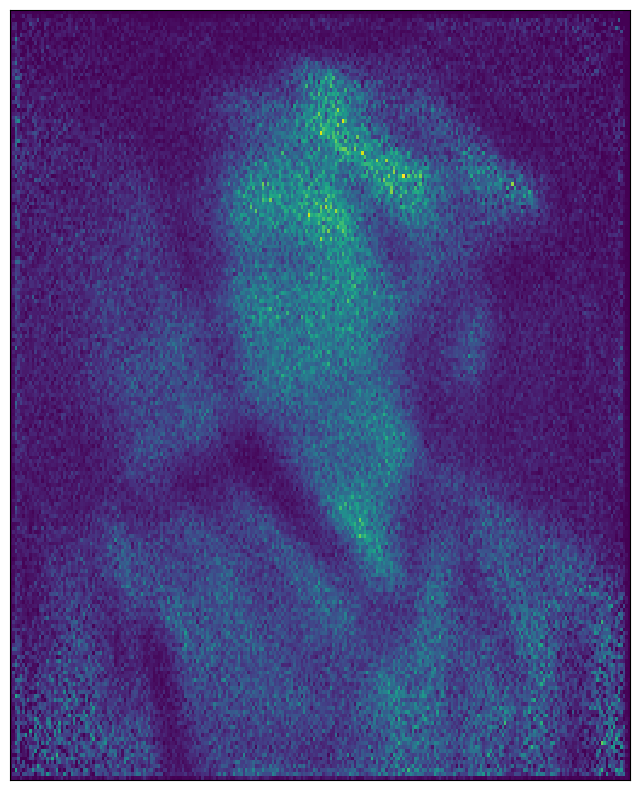

In [28]:
fig, ax = plt.subplots(figsize=(8,10))
plot_image_2d_points(samples, bins = grey.shape)

In [8]:
image = plt.imread('euler.jpg')
grey = rgb2gray(image)
figure = plt.figure(fig)

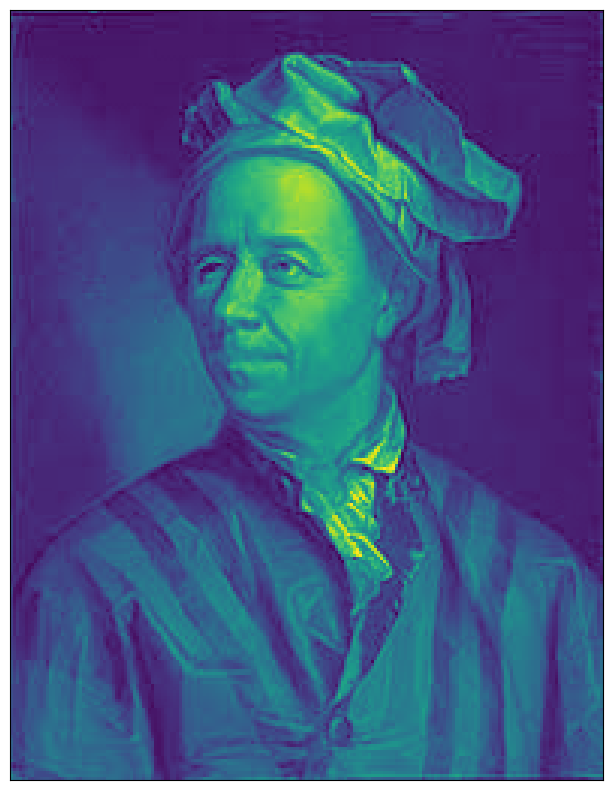

In [10]:
fig, ax = plt.subplots(figsize=(8,10))
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.imshow(grey)